# 深度卷积网络定义

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch08/deep_convnet.py

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为导入父目录中的文件而进行的设置
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """识别率达99%以上的高精度ConvNet
    网络构成如下所示
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 权重初始化===========
        # 每层的每个神经元与前面层的神经元有几个连接（TODO:自动计算）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        weight_init_scales = np.sqrt(2.0 / pre_node_nums)  # 使用ReLU时推荐的初始值
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = weight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = weight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = weight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 生成层===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 设置
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

# 训练上面的网络

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch08/train_deepnet.py

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为导入父目录中的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from deep_convnet import DeepConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

train loss:2.4015404472899804
=== epoch:1, train acc:0.161, test acc:0.162 ===
train loss:2.313922172333037
train loss:2.2858850888317157
train loss:2.354265425877489
train loss:2.274176970261442
train loss:2.268857182259396
train loss:2.234013474896587
train loss:2.263062360321933
train loss:2.2661067091237594
train loss:2.255342243624122
train loss:2.263935404669674
train loss:2.245219664967881
train loss:2.241985033736336
train loss:2.2267605410514886
train loss:2.1777569863816324
train loss:2.200669687623499
train loss:2.145830083821732
train loss:2.1438538382433787
train loss:2.1590821086262797
train loss:2.1103921350375585
train loss:2.118717059497033
train loss:2.1253354848900026
train loss:1.9944096453651485
train loss:1.9740180039991904
train loss:2.069660982358959
train loss:2.088286182894281
train loss:2.0491245677875454
train loss:1.9247030946844996
train loss:1.9757064176854557
train loss:1.982554251459761
train loss:1.9109074832490018
train loss:1.833994083028639
train lo

KeyboardInterrupt: 

# 半精度浮点数网络

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch08/half_float_network.py

In [6]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为导入父目录中的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
#from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 为了运行更快速
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# 类型变化为float16
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))

caluculate accuracy (float64) ... 
0.9935
caluculate accuracy (float16) ... 
0.9935


In [ ]:
# 分类错误的图片

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch08/misclassified_mnist.py

calculating test accuracy ... 
test accuracy:0.9935
======= misclassified result =======
{view index: (label, inference), ...}
{1: (6, 0), 2: (3, 5), 3: (3, 5), 4: (8, 3), 5: (7, 3), 6: (1, 3), 7: (8, 9), 8: (6, 0), 9: (6, 5), 10: (7, 2), 11: (9, 4), 12: (7, 1), 13: (5, 3), 14: (1, 3), 15: (0, 6), 16: (9, 4), 17: (7, 9), 18: (6, 0), 19: (9, 8), 20: (4, 9)}


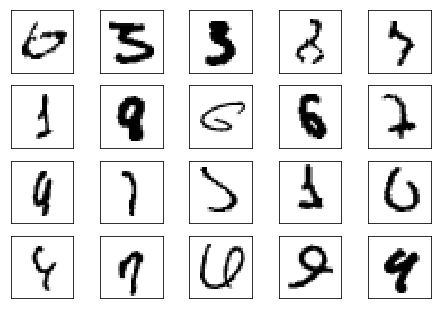

In [8]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为导入父目录中的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
#from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()

# 创建你自己的了不起的网络

https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch08/awesome_net.py

In [9]:
# Create your awesome net!!